In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path


ModuleNotFoundError: No module named 'new_spectral_metric'

In [ ]:
# Lectura de dataset

directorio_dataset = ('../Datasets/Cats and dogs - train')
directorio_dataset = pathlib.Path(directorio_dataset)

imagenes_cats = ('../Datasets/Cats and dogs - train/cats')
imagenes_cats = pathlib.Path(imagenes_cats)

imagenes_dogs = ('../Datasets/Cats and dogs - train/dogs')
imagenes_dogs = pathlib.Path(imagenes_dogs)

total_dataset = len(list(directorio_dataset.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_cats = len(list(imagenes_cats.glob('*.jpg')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_dogs = len(list(imagenes_dogs.glob('*.jpg')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes cats: {total_cats}")
print(f"Total imagenes dogs: {total_dogs}")

Total imagenes dataset: 696
Total imagenes cats: 348
Total imagenes dogs: 348


In [ ]:
# Dimensiones de imagen y tamaño de batch
img_height = 256
img_width = 256
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [ ]:

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 696 files belonging to 2 classes.


In [ ]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")



Número de clases: 2
Los nombres de las clases son: ['cats', 'dogs']


In [ ]:
# Revisar etiquetas de las imágenes
for images, labels in all_images_in_dataset:
    labels = labels.numpy() if hasattr(labels, 'numpy') else labels
    for label in labels:
        assert label in [0, 1], f"Etiqueta inesperada {label} en la imagen."


In [ ]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(696, 256, 256, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


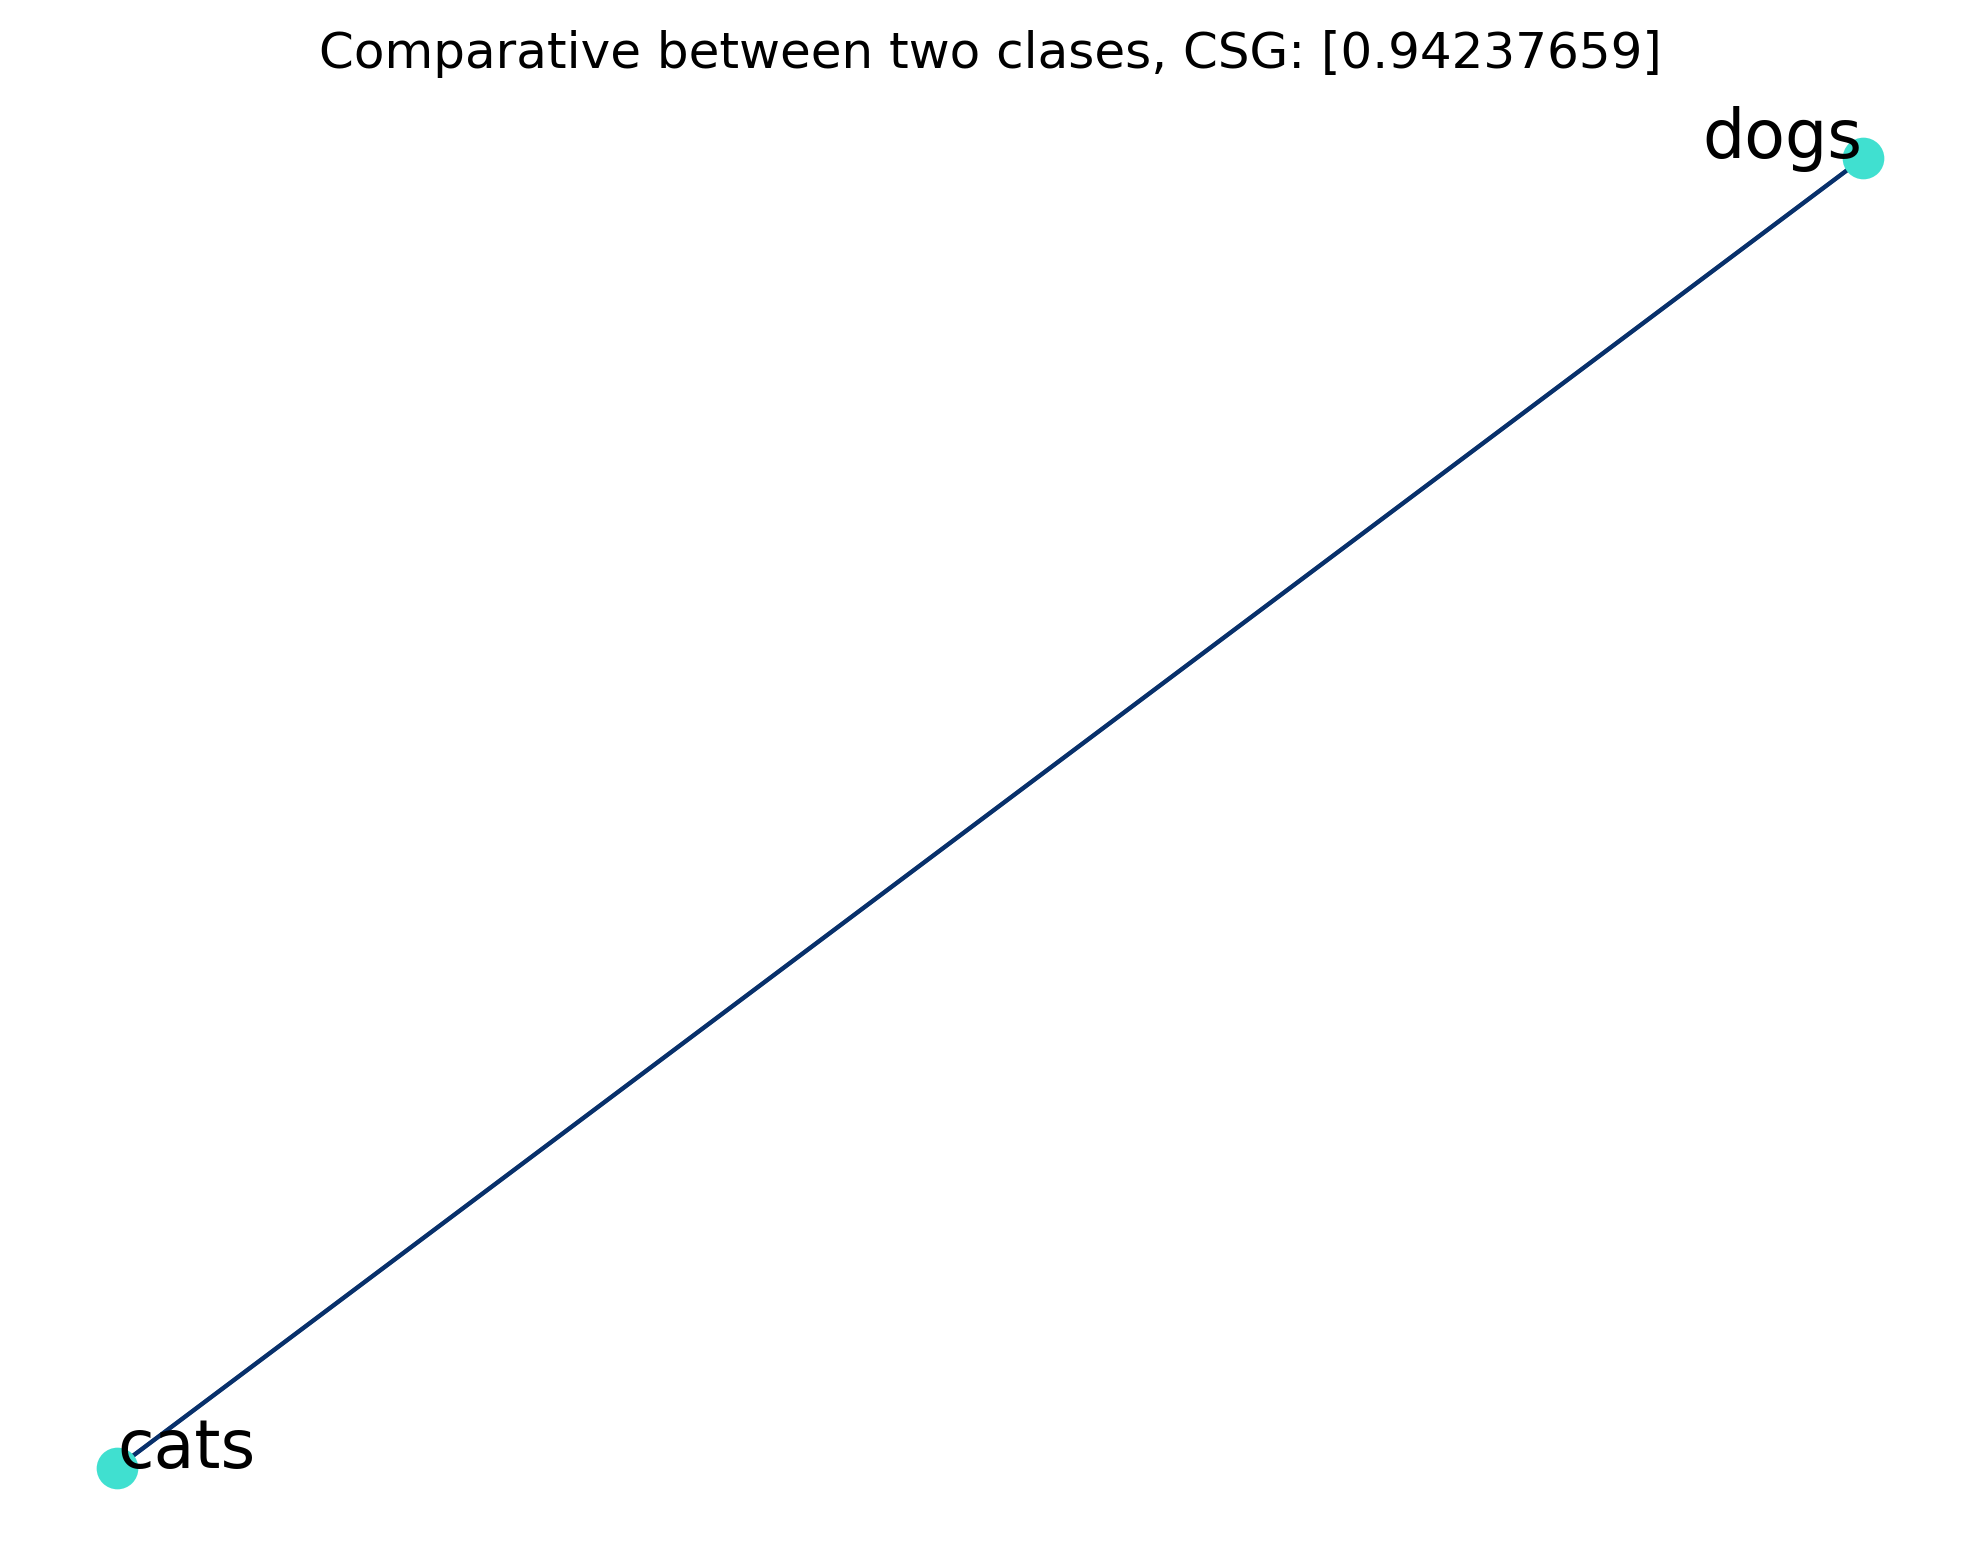

In [ ]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)


# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=348, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

In [ ]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))
print(estimator.W.shape)

Calculo de similitud entre clases
  Clases a comparar  Similitud
0      cats <> dogs   0.942377
(2, 2)


In [ ]:
import numpy as np  

# Suponiendo que `fully_dataset` contiene todas las imágenes y `fully_labels` tiene las etiquetas  

# Obtener índices de las muestras según etiquetas  
first_class_indices = np.where(fully_labels == 0)[0]  # Asumimos que la primera clase es etiquetada como `0`  
second_class_indices = np.where(fully_labels == 1)[0]  

# Seleccionar la primera muestra de la primera clase  
first_class_sample = fully_dataset[first_class_indices[0]].reshape(1, -1)  

# Obtener todas las imágenes de la segunda clase  
second_class_samples = fully_dataset[second_class_indices]  

# Crear un nuevo conjunto de datos que solo tenga 1 de la primera clase y todas las segundas  
combined_samples = np.concatenate((first_class_sample, second_class_samples), axis=0)  

# Actualizar también las etiquetas correspondientes  
combined_labels = np.array([0] + [1] * len(second_class_samples))  

# Inicializar el estimador y ajustar los datos  
estimator = CumulativeGradientEstimator(M_sample=len(combined_labels), k_nearest=10)  
estimator.fit(data=combined_samples, target=combined_labels)  

# Obtener el valor de complejidad (CSG) para esta configuración  
csg = estimator.csg  # Actual complexity values  
print(f"Valor de Complejidad (CSG) para una muestra vs toda la clase: {csg}")  

# Puedes graficar si lo necesitas  
make_graph(estimator.difference, title="Complexity graph, CSG: "+str(csg), classes=["First Class", "Second Class"])